# ResNet-Lite Autoencoder Training (v2)

Training a lighter ResNet-style autoencoder with residual blocks.

**v2 Updates:**
- NaN stability fix in trainer (float32 cast for validation loss)
- NaN batch skipping for numerical stability
- Fresh run name to compare with v1

**Key differences from baseline:**
- Residual blocks with skip connections for better gradient flow
- **ResNet-Lite**: base_channels=32 (~5.6M params vs 22M full ResNet)
- **Mixed Precision (AMP)**: ~2x training speedup
- Same 16x compression (16x16x16 latent)
- Expected: +2-3 dB PSNR improvement over baseline

**Targets:**
- Validation PSNR > 25 dB (baseline achieved ~20.5 dB)
- Training time < 1 day

## 1. Setup and Imports

In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")

Project root: d:\Projects\CNNAutoencoderProject


In [2]:
import torch
import torch.nn as nn

# Project imports
from src.data.datamodule import SARDataModule
from src.models.resnet_autoencoder import ResNetAutoencoder  # ResNet version!
from src.losses.combined import CombinedLoss
from src.training.trainer import Trainer

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 3070
VRAM: 8.0 GB


## 2. Configuration

In [ ]:
# ============================================================
# CONFIGURATION - ResNet-Lite with AMP
# ============================================================

# Data settings
DATA_PATH = "D:/Projects/CNNAutoencoderProject/data/patches/metadata.npy"
BATCH_SIZE = 64       # Can use larger batch with AMP + smaller model
NUM_WORKERS = 0      # Parallel data loading
VAL_FRACTION = 0.1    # 10% validation split
TRAIN_SUBSET = 0.03   # Use 20% of data for faster iteration

# Model settings - LITE VERSION
LATENT_CHANNELS = 16  # 16 = 16x compression
BASE_CHANNELS = 32    # REDUCED from 64 -> ~5.6M params (vs 22M)

# Loss settings
MSE_WEIGHT = 0.5
SSIM_WEIGHT = 0.5

# Training settings
EPOCHS = 20
LEARNING_RATE = 7e-3
EARLY_STOPPING_PATIENCE = 10
LR_PATIENCE = 5
LR_FACTOR = 0.5
MAX_GRAD_NORM = 1.0
USE_AMP = True        # Mixed precision for ~2x speedup

# Output settings
# Base name - trainer will append timestamp for unique TensorBoard runs
# e.g., "resnet_lite_v2_c16" -> "resnet_lite_v2_c16_20260126_143052"
RUN_NAME = f"resnet_lite_v2_c{LATENT_CHANNELS}"

# Calculate compression ratio
compression_ratio = (256 * 256) / (16 * 16 * LATENT_CHANNELS)
print(f"Model: ResNet Autoencoder")
print(f"Base channels: {BASE_CHANNELS} ")
print(f"Compression ratio: {compression_ratio:.0f}x")
print(f"Training subset: {TRAIN_SUBSET*100:.0f}% of data")
print(f"Batch size: {BATCH_SIZE}")
print(f"Mixed Precision (AMP): {USE_AMP}")

## 3. Load Data

In [4]:
print("Loading data...")
dm = SARDataModule(
    patches_path=DATA_PATH,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    val_fraction=VAL_FRACTION,
)

# Apply subset to BOTH train and val for faster iteration
if TRAIN_SUBSET < 1.0:
    import random
    
    # Subset training data
    full_train_size = len(dm.train_dataset)
    train_subset_size = int(full_train_size * TRAIN_SUBSET)
    train_indices = random.sample(range(full_train_size), train_subset_size)
    dm.train_dataset = torch.utils.data.Subset(dm.train_dataset, train_indices)
    
    # Subset validation data (same proportion)
    full_val_size = len(dm.val_dataset)
    val_subset_size = int(full_val_size * TRAIN_SUBSET)
    val_indices = random.sample(range(full_val_size), val_subset_size)
    dm.val_dataset = torch.utils.data.Subset(dm.val_dataset, val_indices)
    
    print(f"Using {TRAIN_SUBSET*100:.0f}% subset:")
    print(f"  Train: {train_subset_size:,} of {full_train_size:,}")
    print(f"  Val: {val_subset_size:,} of {full_val_size:,}")

train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

print(f"\nDataset loaded:")
print(f"  Train patches: {len(dm.train_dataset):,}")
print(f"  Val patches: {len(dm.val_dataset):,}")
print(f"  Train batches: {len(train_loader):,}")
print(f"  Val batches: {len(val_loader):,}")
print(f"  Preprocessing params: {dm.preprocessing_params}")

# Estimate epoch time
est_batches = len(train_loader) + len(val_loader)
est_time_min = est_batches / 1.5 / 60  # ~1.5 it/s with larger model
print(f"\n  Estimated time per epoch: ~{est_time_min:.0f} minutes")

Loading data...
Loading metadata from D:\Projects\CNNAutoencoderProject\data\patches\metadata.npy
Total patches: 696277
Train: 626650, Val: 69627
Using 3% subset:
  Train: 18,799 of 626,650
  Val: 2,088 of 69,627

Dataset loaded:
  Train patches: 18,799
  Val patches: 2,088
  Train batches: 293
  Val batches: 33
  Preprocessing params: {'vmin': np.float32(14.768799), 'vmax': np.float32(24.54073)}

  Estimated time per epoch: ~4 minutes


In [5]:
# Verify a sample batch
sample_batch = next(iter(train_loader))
print(f"Sample batch shape: {sample_batch.shape}")
print(f"Sample batch dtype: {sample_batch.dtype}")
print(f"Sample batch range: [{sample_batch.min():.4f}, {sample_batch.max():.4f}]")

Sample batch shape: torch.Size([64, 1, 256, 256])
Sample batch dtype: torch.float32
Sample batch range: [0.0000, 1.0000]


## 4. Create Model

In [6]:
print("Creating ResNet model...")
model = ResNetAutoencoder(
    latent_channels=LATENT_CHANNELS,
    base_channels=BASE_CHANNELS,
)

params = model.count_parameters()
print(f"\nModel created:")
print(f"  Architecture: ResNetAutoencoder")
print(f"  Total parameters: {params['total']:,}")
print(f"  Encoder params: {params['encoder']:,}")
print(f"  Decoder params: {params['decoder']:,}")
print(f"  Compression ratio: {model.get_compression_ratio():.1f}x")
print(f"  Latent size: {model.get_latent_size()}")

# Compare to baseline
baseline_params = 2_257_809
print(f"\n  vs Baseline: {params['total'] / baseline_params:.1f}x more parameters")

Creating ResNet model...

Model created:
  Architecture: ResNetAutoencoder
  Total parameters: 5,648,033
  Encoder params: 2,820,544
  Decoder params: 2,827,489
  Compression ratio: 16.0x
  Latent size: (16, 16, 16)

  vs Baseline: 2.5x more parameters


In [7]:
# Test forward pass
print("Testing forward pass...")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_test = model.to(device)
x_test = sample_batch[:2].to(device)

with torch.no_grad():
    x_hat, z = model_test(x_test)

print(f"  Input: {x_test.shape}")
print(f"  Latent: {z.shape}")
print(f"  Output: {x_hat.shape}")
print(f"  Output range: [{x_hat.min():.4f}, {x_hat.max():.4f}]")

# Check GPU memory
if torch.cuda.is_available():
    print(f"  GPU memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

# Clean up test
del model_test, x_test, x_hat, z
torch.cuda.empty_cache()

Testing forward pass...
  Input: torch.Size([2, 1, 256, 256])
  Latent: torch.Size([2, 16, 16, 16])
  Output: torch.Size([2, 1, 256, 256])
  Output range: [0.0000, 1.0000]
  GPU memory allocated: 0.02 GB


## 5. Create Loss Function

In [8]:
loss_fn = CombinedLoss(
    mse_weight=MSE_WEIGHT,
    ssim_weight=SSIM_WEIGHT,
)

print(f"Loss function: CombinedLoss")
print(f"  MSE weight: {MSE_WEIGHT}")
print(f"  SSIM weight: {SSIM_WEIGHT}")

Loss function: CombinedLoss
  MSE weight: 0.5
  SSIM weight: 0.5


In [9]:
# # %% Diagnose training speed bottleneck
# import gc
# import time

# # Clear GPU memory
# gc.collect()
# torch.cuda.empty_cache()

# # Fresh model
# model = ResNetAutoencoder(
#     latent_channels=LATENT_CHANNELS,
#     base_channels=BASE_CHANNELS,
# )
# model.train().cuda()
# loss_fn.cuda()

# print(f"GPU memory with model: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

# # Warm up
# batch_iter = iter(train_loader)
# _ = next(batch_iter)

# # Time data loading
# t0 = time.time()
# batch = next(batch_iter)
# t_load = time.time() - t0

# # Time GPU transfer
# t0 = time.time()
# batch = batch[:8].cuda()  # Small batch to avoid OOM
# torch.cuda.synchronize()
# t_transfer = time.time() - t0

# # Time forward pass
# t0 = time.time()
# out, _ = model(batch)
# torch.cuda.synchronize()
# t_forward = time.time() - t0

# # Time loss
# t0 = time.time()
# loss, _ = loss_fn(out, batch)
# torch.cuda.synchronize()
# t_loss = time.time() - t0

# # Time backward pass
# t0 = time.time()
# loss.backward()
# torch.cuda.synchronize()
# t_backward = time.time() - t0

# # Cleanup
# del out, loss, batch
# torch.cuda.empty_cache()

# print(f"\nData loading:  {t_load:.3f}s")
# print(f"GPU transfer:  {t_transfer:.3f}s")
# print(f"Forward pass:  {t_forward:.3f}s")
# print(f"Loss compute:  {t_loss:.3f}s")
# print(f"Backward pass: {t_backward:.3f}s")
# print(f"Total:         {t_load + t_transfer + t_forward + t_loss + t_backward:.3f}s")

# times = {'Data loading': t_load, 'GPU transfer': t_transfer, 'Forward': t_forward, 'Loss': t_loss, 'Backward': t_backward}
# print(f"\nBottleneck: {max(times, key=times.get)}")

## Finding optimal learning rate

In [10]:


from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
def find_lr_minimal(model, sample_batch, loss_fn, device='cuda',
                    start_lr=1e-7, end_lr=1, num_iter=100):
    
    print("Saving initial state...")
    initial_state = {k: v.clone() for k, v in model.state_dict().items()}
    
    print("Moving model to device...")
    model.train()
    model.to(device)
    
    print("Moving batch to device...")
    batch = sample_batch.to(device)
    print(f"Batch on device: {batch.device}, shape: {batch.shape}")
    
    print("Creating optimizer...")
    optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr, weight_decay=1e-4)
    gamma = (end_lr / start_lr) ** (1 / num_iter)
    
    lrs, losses = [], []
    smoothed_loss = None
    best_loss = float('inf')
    
    print("Starting LR sweep...")
    for i in tqdm(range(num_iter), desc="LR sweep"):
        optimizer.zero_grad()
        output, _ = model(batch)
        loss, _ = loss_fn(output, batch)
        
        if torch.isnan(loss) or loss.item() > 4 * best_loss:
            print(f"\nStopped at iter {i}: lr={optimizer.param_groups[0]['lr']:.2e}")
            break
        
        lrs.append(optimizer.param_groups[0]['lr'])
        
        if smoothed_loss is None:
            smoothed_loss = loss.item()
        else:
            smoothed_loss = 0.1 * loss.item() + 0.9 * smoothed_loss
        losses.append(smoothed_loss)
        best_loss = min(best_loss, smoothed_loss)
        
        loss.backward()
        optimizer.step()
        
        for pg in optimizer.param_groups:
            pg['lr'] *= gamma
    
    print("Restoring initial state...")
    model.load_state_dict(initial_state)
    return np.array(lrs), np.array(losses)


# Run with smaller batch if needed
sample = next(iter(train_loader))
print(f"Got batch: {sample.shape}")

# Try with just 4 samples to test
lrs, losses = find_lr_minimal(
    model=model,
    sample_batch=sample[:4],  # Just 4 samples
    loss_fn=loss_fn,
    num_iter=100
)

Got batch: torch.Size([64, 1, 256, 256])
Saving initial state...
Moving model to device...
Moving batch to device...
Batch on device: cuda:0, shape: torch.Size([4, 1, 256, 256])
Creating optimizer...
Starting LR sweep...


LR sweep: 100%|██████████| 100/100 [00:08<00:00, 11.78it/s]

Restoring initial state...


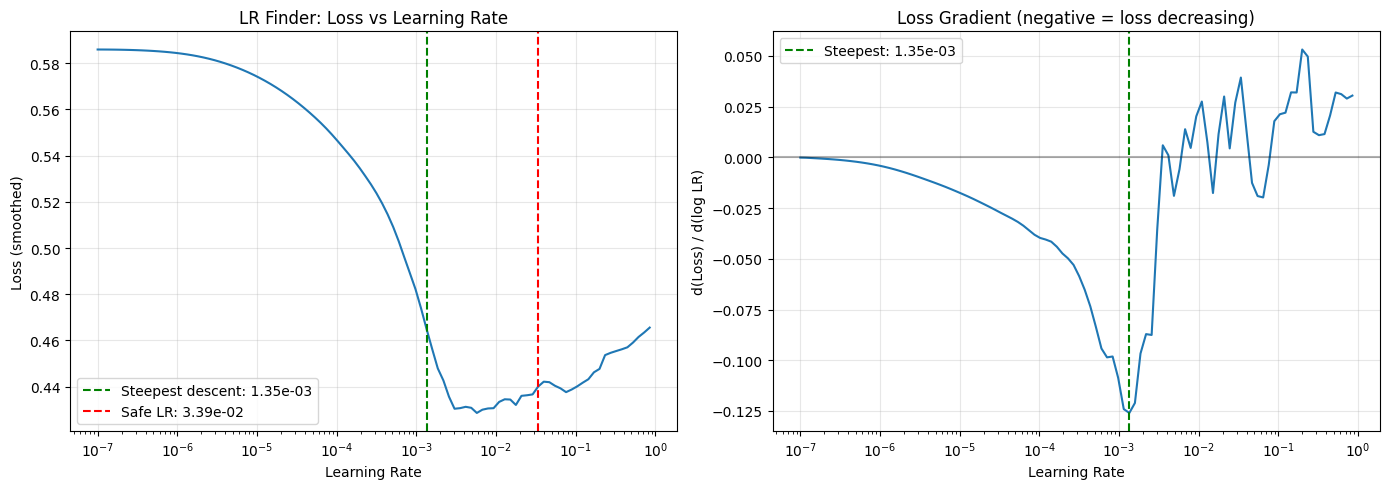


Minimum loss at LR: 5.75e-03
Suggested max_lr: 5.75e-04

⚠️  Recreate model before training!

Learning Rate Recommendations
Steepest descent LR:  5.75e-04
Safe LR (before explosion): 3.39e-02

Recommended range to try:
  Conservative: 1.92e-04
  Aggressive:   5.75e-04

For OneCycleLR, set max_lr to: 5.75e-04


In [11]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss vs LR (log scale)
ax1 = axes[0]
ax1.plot(lrs, losses)
ax1.set_xscale('log')
ax1.set_xlabel('Learning Rate')
ax1.set_ylabel('Loss (smoothed)')
ax1.set_title('LR Finder: Loss vs Learning Rate')
ax1.grid(True, alpha=0.3)

# Find suggested LR (steepest descent point)
# Compute gradient of loss w.r.t. log(lr)
log_lrs = np.log10(lrs)
gradients = np.gradient(losses, log_lrs)

# Find the point of steepest descent (most negative gradient)
# But only consider the region before loss starts increasing
min_loss_idx = np.argmin(losses)
search_region = gradients[:min_loss_idx] if min_loss_idx > 10 else gradients[:len(gradients)//2]
steepest_idx = np.argmin(search_region)
suggested_lr = lrs[steepest_idx]

# Alternative: pick LR one order of magnitude below explosion
# Find where loss starts increasing significantly
for i in range(len(losses) - 1):
    if losses[i+1] > losses[i] * 1.5:  # Loss increased by 50%
        explosion_idx = i
        break
else:
    explosion_idx = len(losses) - 1

safe_lr = lrs[max(0, explosion_idx - 20)]  # Back off ~20 steps

ax1.axvline(x=suggested_lr, color='g', linestyle='--', label=f'Steepest descent: {suggested_lr:.2e}')
ax1.axvline(x=safe_lr, color='r', linestyle='--', label=f'Safe LR: {safe_lr:.2e}')
ax1.legend()

# Plot 2: Gradient of loss (to see steepest descent)
ax2 = axes[1]
ax2.plot(lrs, gradients)
ax2.set_xscale('log')
ax2.set_xlabel('Learning Rate')
ax2.set_ylabel('d(Loss) / d(log LR)')
ax2.set_title('Loss Gradient (negative = loss decreasing)')
ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax2.axvline(x=suggested_lr, color='g', linestyle='--', label=f'Steepest: {suggested_lr:.2e}')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig(f'{project_root}/notebooks/runs/{RUN_NAME}/lr_finder.png', dpi=150)
plt.show()

min_idx = np.argmin(losses)
suggested_lr = lrs[min_idx] / 10
print(f"\nMinimum loss at LR: {lrs[min_idx]:.2e}")
print(f"Suggested max_lr: {suggested_lr:.2e}")

# IMPORTANT: Recreate model before training - this one is corrupted
print("\n⚠️  Recreate model before training!")

# Print recommendations
print("\n" + "=" * 60)
print("Learning Rate Recommendations")
print("=" * 60)
print(f"Steepest descent LR:  {suggested_lr:.2e}")
print(f"Safe LR (before explosion): {safe_lr:.2e}")
print(f"\nRecommended range to try:")
print(f"  Conservative: {suggested_lr/3:.2e}")
print(f"  Aggressive:   {suggested_lr:.2e}")
print(f"\nFor OneCycleLR, set max_lr to: {suggested_lr:.2e}")
print("=" * 60)

In [12]:
print("Recreating model with fresh weights...")
model = ResNetAutoencoder(
    latent_channels=LATENT_CHANNELS,
    base_channels=BASE_CHANNELS,
)
print(f"Model recreated: {model.count_parameters()['total']:,} params")

Recreating model with fresh weights...
Model recreated: 5,648,033 params


## 6. Initialize Trainer

In [13]:
# Training configuration
config = {
    'learning_rate': LEARNING_RATE,
    'lr_patience': LR_PATIENCE,
    'scheduler': 'onecycle',
    'lr_factor': LR_FACTOR,
    'max_grad_norm': MAX_GRAD_NORM,
    'run_name': RUN_NAME,
    'preprocessing_params': dm.preprocessing_params,
    'use_amp': USE_AMP,  # Mixed precision training
    # Store hyperparams for reproducibility
    'model_type': 'ResNetAutoencoder-Lite',
    'latent_channels': LATENT_CHANNELS,
    'base_channels': BASE_CHANNELS,
    'mse_weight': MSE_WEIGHT,
    'ssim_weight': SSIM_WEIGHT,
    'batch_size': BATCH_SIZE,
    'epochs': EPOCHS,
    'optimiser': "adamw",
}

print("Initializing trainer...")
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    config=config,
)

print(f"\nTrainer ready:")
print(f"  Log dir: {trainer.log_dir}")
print(f"  Checkpoint dir: {trainer.checkpoint_dir}")
print(f"  Device: {trainer.device}")
print(f"  AMP enabled: {trainer.use_amp}")

2026-01-26 19:54:52,189 - Log directory: runs\resnet_lite_v2_c16
2026-01-26 19:54:52,189 - Checkpoint directory: checkpoints\resnet_lite_v2_c16
2026-01-26 19:54:52,191 - Mixed Precision (AMP): enabled


Initializing trainer...
Using device: cuda
GPU memory: 2666MB / 8192MB (33% used, 5.4 GB free)
Using OneCycleLR: max_lr=7.00e-03, 5860 total steps
Mixed Precision (AMP) enabled - ~2x training speedup

Trainer ready:
  Log dir: runs\resnet_lite_v2_c16
  Checkpoint dir: checkpoints\resnet_lite_v2_c16
  Device: cuda
  AMP enabled: True


In [14]:
# %% Diagnose why training is slow
import gc
import time

gc.collect()
torch.cuda.empty_cache()

# Check what model is actually being used
print("=" * 60)
print("DIAGNOSTIC")
print("=" * 60)

print(f"\n1. Config check:")
print(f"   BASE_CHANNELS = {BASE_CHANNELS}")
print(f"   BATCH_SIZE = {BATCH_SIZE}")
print(f"   TRAIN_SUBSET = {TRAIN_SUBSET}")
print(f"   NUM_WORKERS = {NUM_WORKERS}")

print(f"\n2. Data check:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

print(f"\n3. Model check:")
print(f"   Model base_channels: {model.base_channels if hasattr(model, 'base_channels') else 'unknown'}")
print(f"   Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Time one full training batch cycle
model.train().cuda()
loss_fn.cuda()

batch = next(iter(train_loader)).cuda()
print(f"\n4. Batch shape: {batch.shape}")

# Warm up
with torch.cuda.amp.autocast(enabled=USE_AMP):
    out, _ = model(batch)
    loss, _ = loss_fn(out, batch)
loss.backward()
torch.cuda.synchronize()

# Time it
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

torch.cuda.synchronize()
t0 = time.time()

optimizer.zero_grad()
with torch.cuda.amp.autocast(enabled=USE_AMP):
    out, _ = model(batch)
    loss, _ = loss_fn(out, batch)
scaler.scale(loss).backward()
scaler.step(optimizer)
scaler.update()

torch.cuda.synchronize()
batch_time = time.time() - t0

print(f"\n5. Timing:")
print(f"   Single batch (full cycle): {batch_time:.3f}s")
print(f"   Expected epoch time: {len(train_loader) * batch_time / 60:.1f} minutes")
print(f"   Expected val time: {len(val_loader) * batch_time / 60:.1f} minutes")

# Check data loading speed
t0 = time.time()
for i, b in enumerate(train_loader):
    if i >= 10:
        break
t_load = (time.time() - t0) / 10
print(f"   Avg data loading per batch: {t_load:.3f}s")

print("=" * 60)

# Cleanup
del out, loss, batch, optimizer, scaler
torch.cuda.empty_cache()

DIAGNOSTIC

1. Config check:
   BASE_CHANNELS = 32
   BATCH_SIZE = 64
   TRAIN_SUBSET = 0.03
   NUM_WORKERS = 0

2. Data check:
   Train batches: 293
   Val batches: 33

3. Model check:
   Model base_channels: 32
   Model parameters: 5,648,033

4. Batch shape: torch.Size([64, 1, 256, 256])


C:\Users\amdc1\AppData\Local\Temp\ipykernel_38752\2021521091.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
C:\Users\amdc1\AppData\Local\Temp\ipykernel_38752\2021521091.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
C:\Users\amdc1\AppData\Local\Temp\ipykernel_38752\2021521091.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):



5. Timing:
   Single batch (full cycle): 16.624s
   Expected epoch time: 81.2 minutes
   Expected val time: 9.1 minutes
   Avg data loading per batch: 0.101s


In [ ]:
# %% Test: Is it just first-op overhead?
import time

# Already warmed up from previous cell, so this should be fast
model.train().cuda()
batch = next(iter(train_loader)).cuda()

times = []
for i in range(5):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer.zero_grad()
    
    torch.cuda.synchronize()
    t0 = time.time()
    
    with torch.amp.autocast('cuda', enabled=USE_AMP):
        out, _ = model(batch)
        loss, _ = loss_fn(out, batch)
    loss.backward()
    optimizer.step()
    
    torch.cuda.synchronize()
    times.append(time.time() - t0)
    print(f"Batch {i+1}: {times[-1]:.3f}s")

print(f"\nFirst batch: {times[0]:.3f}s")
print(f"Avg of batches 2-5: {sum(times[1:])/4:.3f}s")

del out, loss, batch, optimizer
torch.cuda.empty_cache()# %% Test: Is it just first-op overhead?
import time

# Already warmed up from previous cell, so this should be fast
model.train().cuda()
batch = next(iter(train_loader)).cuda()

times = []
for i in range(5):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer.zero_grad()
    
    torch.cuda.synchronize()
    t0 = time.time()
    
    with torch.amp.autocast('cuda', enabled=USE_AMP):
        out, _ = model(batch)
        loss, _ = loss_fn(out, batch)
    loss.backward()
    optimizer.step()
    
    torch.cuda.synchronize()
    times.append(time.time() - t0)
    print(f"Batch {i+1}: {times[-1]:.3f}s")

print(f"\nFirst batch: {times[0]:.3f}s")
print(f"Avg of batches 2-5: {sum(times[1:])/4:.3f}s")

del out, loss, batch, optimizer
torch.cuda.empty_cache()

Batch 1: 6.437s


## 7. Train Model

**Monitor with TensorBoard:**
```bash
tensorboard --logdir=D:/Projects/CNNAutoencoderProject/notebooks/runs
```

Compare `resnet_c16` with `baseline_c16_fast` in TensorBoard.

In [37]:
# checkpoint_path = Path(f"{project_root}/notebooks/checkpoints/{RUN_NAME}/latest.pth")

# if checkpoint_path.exists():
#     trainer.load_checkpoint(checkpoint_path)
#     print(f"Resumed from epoch {trainer.epoch}, best_val_loss={trainer.best_val_loss:.4f}")
# else:
#     print("No checkpoint found, starting fresh")

In [39]:
print("=" * 60)
print("Starting ResNet Training")
print("=" * 60)
print(f"Model: ResNetAutoencoder ({params['total']:,} params)")
print(f"Epochs: {EPOCHS}")
print(f"Early stopping patience: {EARLY_STOPPING_PATIENCE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"\nTensorBoard: tensorboard --logdir={trainer.log_dir.parent}")
print(f"Checkpoints: {trainer.checkpoint_dir}")
print("=" * 60)

history = trainer.train(
    epochs=EPOCHS,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
)

2026-01-26 19:49:39,462 - Starting training for 20 epochs
2026-01-26 19:49:39,462 - Model: ResNetAutoencoder
2026-01-26 19:49:39,462 - Config: {'learning_rate': 0.007, 'lr_patience': 5, 'scheduler': 'onecycle', 'lr_factor': 0.5, 'max_grad_norm': 1.0, 'run_name': 'resnet_lite_v2_c16', 'preprocessing_params': {'vmin': np.float32(14.768799), 'vmax': np.float32(24.54073)}, 'use_amp': True, 'model_type': 'ResNetAutoencoder-Lite', 'latent_channels': 16, 'base_channels': 32, 'mse_weight': 0.5, 'ssim_weight': 0.5, 'batch_size': 64, 'epochs': 20, 'optimiser': 'adamw'}
2026-01-26 19:49:39,464 - Training complete. Best val loss: 0.1410


Starting ResNet Training
Model: ResNetAutoencoder (5,648,033 params)
Epochs: 20
Early stopping patience: 10
Learning rate: 0.007

TensorBoard: tensorboard --logdir=runs
Checkpoints: checkpoints\resnet_lite_v2_c16


In [19]:
# Load results from checkpoint if training wasn't run in this session
# This allows viewing results without re-running training

checkpoint_path = Path(f"checkpoints/{RUN_NAME}/best.pth")

if 'history' not in dir() or history is None:
    print("Training was not run in this session. Loading from checkpoint...")
    
    if checkpoint_path.exists():
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        
        # Load model weights
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        print(f"✓ Loaded model from: {checkpoint_path}")
        
        # Reconstruct summary from checkpoint
        history = None  # No epoch-by-epoch history available
        
        # Get best metrics from checkpoint (if saved by trainer)
        best_val_loss = checkpoint.get('best_val_loss', None)
        best_epoch = checkpoint.get('epoch', 'unknown')
        
        # Run quick validation to get current metrics
        print("Running validation to get metrics...")
        model.to('cuda' if torch.cuda.is_available() else 'cpu')
        
        val_losses, val_psnrs, val_ssims = [], [], []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(next(model.parameters()).device)
                output, _ = model(batch)
                loss, metrics = loss_fn(output, batch)
                val_losses.append(loss.item())
                val_psnrs.append(metrics['psnr'])
                val_ssims.append(metrics['ssim'])
        
        loaded_metrics = {
            'val_loss': sum(val_losses) / len(val_losses),
            'val_psnr': sum(val_psnrs) / len(val_psnrs),
            'val_ssim': sum(val_ssims) / len(val_ssims),
            'epoch': best_epoch,
        }
        print(f"✓ Validation complete")
        print(f"  Val Loss: {loaded_metrics['val_loss']:.4f}")
        print(f"  Val PSNR: {loaded_metrics['val_psnr']:.2f} dB")
        print(f"  Val SSIM: {loaded_metrics['val_ssim']:.4f}")
    else:
        print(f"✗ No checkpoint found at: {checkpoint_path}")
        print("  Please run training first (Cell 17)")
        loaded_metrics = None
else:
    print("Training history available from this session.")
    loaded_metrics = None  # Use history instead

Training history available from this session.


In [20]:
print("=" * 60)
print("Training Summary")
print("=" * 60)

# Use history if available (training run this session), otherwise use loaded_metrics
if history:
    final = history[-1]
    print(f"Model: ResNetAutoencoder")
    print(f"Final epoch: {final['epoch'] + 1}")
    print(f"Best val loss: {trainer.best_val_loss:.4f}")
    print(f"Final val PSNR: {final['val_psnr']:.2f} dB")
    print(f"Final val SSIM: {final['val_ssim']:.4f}")
    
    # Compare to baseline
    baseline_psnr = 20.47
    improvement = final['val_psnr'] - baseline_psnr
    print(f"\nImprovement over baseline: {improvement:+.2f} dB")
    
    if final['val_psnr'] >= 25:
        print("\n" + "=" * 60)
        print("[SUCCESS] PSNR > 25 dB achieved!")
        print("=" * 60)
    else:
        print(f"\n[INFO] PSNR {final['val_psnr']:.2f} dB (target: 25 dB)")

elif loaded_metrics:
    print(f"Model: ResNetAutoencoder (loaded from checkpoint)")
    print(f"Val Loss: {loaded_metrics['val_loss']:.4f}")
    print(f"Val PSNR: {loaded_metrics['val_psnr']:.2f} dB")
    print(f"Val SSIM: {loaded_metrics['val_ssim']:.4f}")
    
    # Compare to baseline
    baseline_psnr = 20.47
    improvement = loaded_metrics['val_psnr'] - baseline_psnr
    print(f"\nImprovement over baseline: {improvement:+.2f} dB")
    
    if loaded_metrics['val_psnr'] >= 25:
        print("\n" + "=" * 60)
        print("[SUCCESS] PSNR > 25 dB achieved!")
        print("=" * 60)
    else:
        print(f"\n[INFO] PSNR {loaded_metrics['val_psnr']:.2f} dB (target: 25 dB)")
else:
    print("[ERROR] No training history or checkpoint available.")
    print("Please run training (Cell 17) first.")

print(f"\nCheckpoint: checkpoints/{RUN_NAME}/best.pth")

Training Summary
Model: ResNetAutoencoder
Final epoch: 29
Best val loss: 0.1410
Final val PSNR: 20.91 dB
Final val SSIM: 0.7261

Improvement over baseline: +0.44 dB

[INFO] PSNR 20.91 dB (target: 25 dB)

Checkpoint: checkpoints/resnet_lite_v2_c16/best.pth


## 9. Comparison with Baseline

In [21]:
# Comparison table
print("\n" + "=" * 75)
print("Model Comparison")
print("=" * 75)

baseline_results = {
    'params': 2_257_809,
    'psnr': 20.47,
    'ssim': 0.646,
    'loss': 0.1813
}

# Get ResNet results from history or loaded_metrics
if history:
    final = history[-1]
    resnet_results = {
        'params': params['total'],
        'psnr': final['val_psnr'],
        'ssim': final['val_ssim'],
        'loss': final['val_loss']
    }
elif loaded_metrics:
    resnet_results = {
        'params': params['total'],
        'psnr': loaded_metrics['val_psnr'],
        'ssim': loaded_metrics['val_ssim'],
        'loss': loaded_metrics['val_loss']
    }
else:
    resnet_results = None

if resnet_results:
    print(f"{'Metric':<20} {'Baseline':>15} {'ResNet-Lite':>15} {'Diff':>15}")
    print("-" * 75)
    
    # Parameters
    diff_params = f"{resnet_results['params']/baseline_results['params']:.1f}x"
    print(f"{'Parameters':<20} {baseline_results['params']:>15,} {resnet_results['params']:>15,} {diff_params:>15}")
    
    # PSNR
    diff_psnr = resnet_results['psnr'] - baseline_results['psnr']
    print(f"{'Val PSNR (dB)':<20} {baseline_results['psnr']:>15.2f} {resnet_results['psnr']:>15.2f} {diff_psnr:>+15.2f}")
    
    # SSIM
    diff_ssim = resnet_results['ssim'] - baseline_results['ssim']
    print(f"{'Val SSIM':<20} {baseline_results['ssim']:>15.3f} {resnet_results['ssim']:>15.3f} {diff_ssim:>+15.3f}")
    
    # Loss
    diff_loss = resnet_results['loss'] - baseline_results['loss']
    print(f"{'Val Loss':<20} {baseline_results['loss']:>15.4f} {resnet_results['loss']:>15.4f} {diff_loss:>+15.4f}")
    
    print("=" * 75)
else:
    print("No ResNet results available. Please run training or load checkpoint first.")


Model Comparison
Metric                      Baseline     ResNet-Lite            Diff
---------------------------------------------------------------------------
Parameters                 2,257,809       5,648,033            2.5x
Val PSNR (dB)                  20.47           20.91           +0.44
Val SSIM                       0.646           0.726          +0.080
Val Loss                      0.1813          0.1410         -0.0403


## 10. Visualize Training History

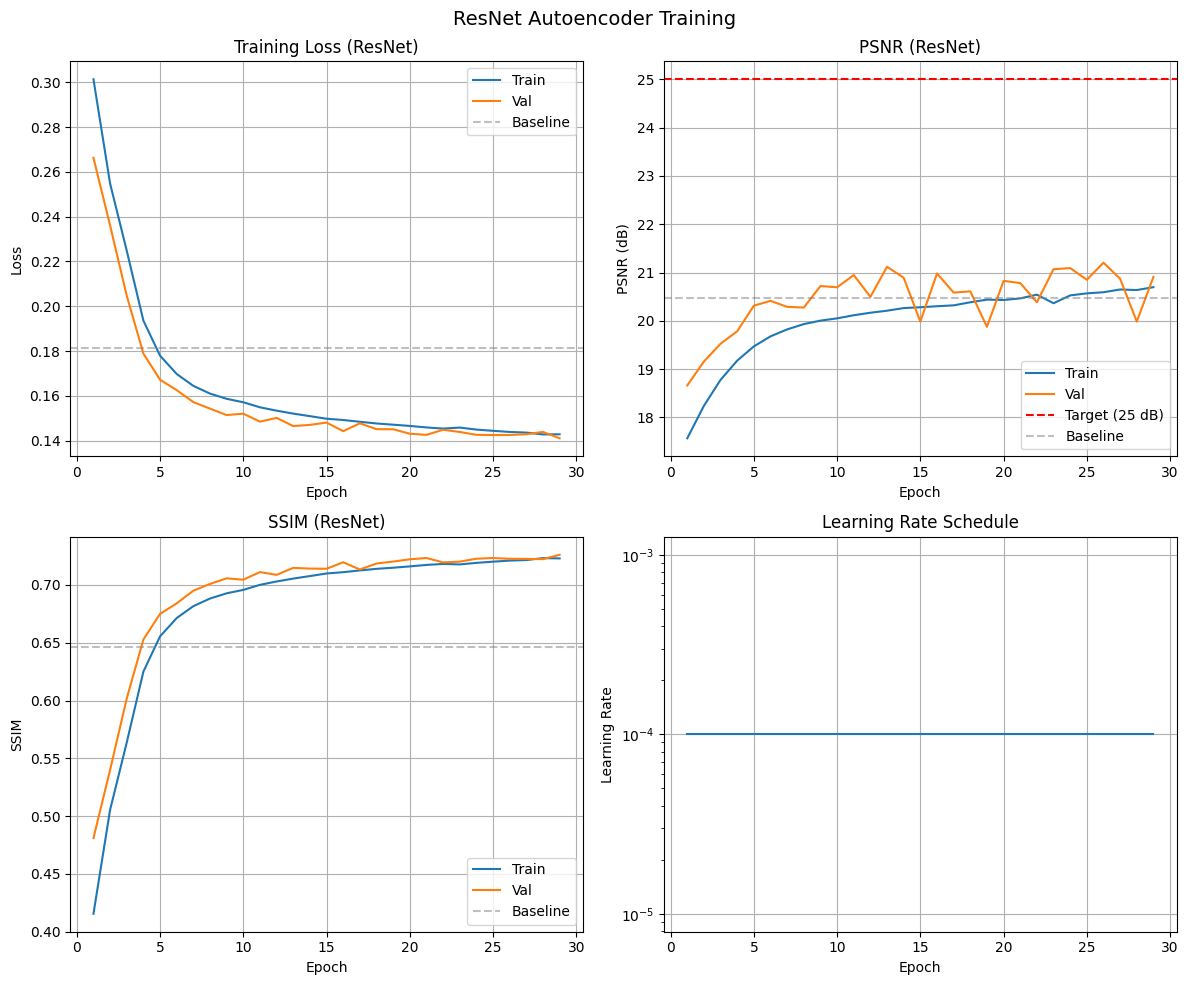


Saved training curves to: runs\resnet_lite_v2_c16\training_curves.png


In [22]:


if history:
    epochs_list = [h['epoch'] + 1 for h in history]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Loss
    ax = axes[0, 0]
    ax.plot(epochs_list, [h['train_loss'] for h in history], label='Train')
    ax.plot(epochs_list, [h['val_loss'] for h in history], label='Val')
    ax.axhline(y=baseline_results['loss'], color='gray', linestyle='--', alpha=0.5, label='Baseline')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss (ResNet)')
    ax.legend()
    ax.grid(True)
    
    # PSNR
    ax = axes[0, 1]
    ax.plot(epochs_list, [h['train_psnr'] for h in history], label='Train')
    ax.plot(epochs_list, [h['val_psnr'] for h in history], label='Val')
    ax.axhline(y=25, color='r', linestyle='--', label='Target (25 dB)')
    ax.axhline(y=baseline_results['psnr'], color='gray', linestyle='--', alpha=0.5, label='Baseline')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('PSNR (dB)')
    ax.set_title('PSNR (ResNet)')
    ax.legend()
    ax.grid(True)
    
    # SSIM
    ax = axes[1, 0]
    ax.plot(epochs_list, [h['train_ssim'] for h in history], label='Train')
    ax.plot(epochs_list, [h['val_ssim'] for h in history], label='Val')
    ax.axhline(y=baseline_results['ssim'], color='gray', linestyle='--', alpha=0.5, label='Baseline')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('SSIM')
    ax.set_title('SSIM (ResNet)')
    ax.legend()
    ax.grid(True)
    
    # Learning Rate
    ax = axes[1, 1]
    ax.plot(epochs_list, [h['learning_rate'] for h in history])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Learning Rate')
    ax.set_title('Learning Rate Schedule')
    ax.set_yscale('log')
    ax.grid(True)
    
    plt.suptitle('ResNet Autoencoder Training', fontsize=14)
    plt.tight_layout()
    
    # Save to log_dir if available, otherwise to current dir
    save_path = Path(f"runs/{RUN_NAME}/training_curves.png")
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=150)
    plt.show()
    
    print(f"\nSaved training curves to: {save_path}")
else:
    print("Training curves not available (model loaded from checkpoint).")
    print("Epoch-by-epoch history is only saved during training.")
    print(f"\nCheck TensorBoard for historical curves:")
    print(f"  tensorboard --logdir=runs/{RUN_NAME}")

## 11. Sample Reconstructions

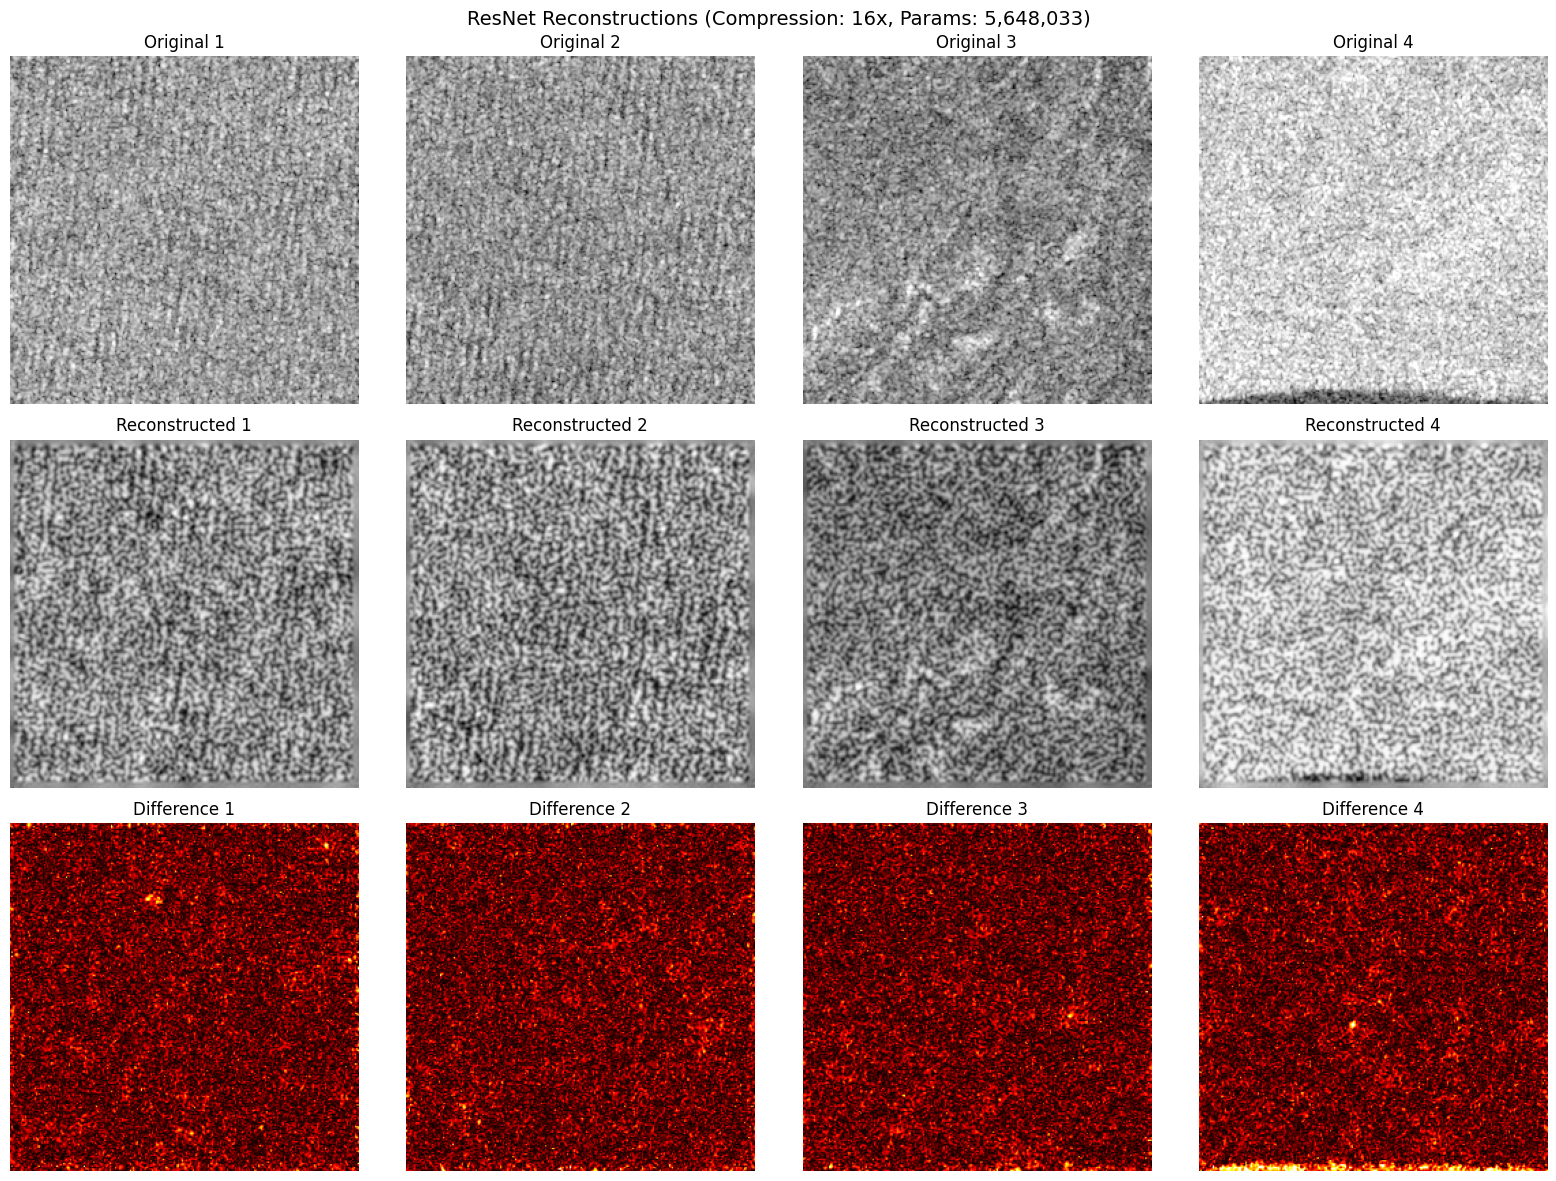

In [23]:
# Visualize some sample reconstructions
import matplotlib.pyplot as plt

model.eval()
device = next(model.parameters()).device

# Get a batch from validation
val_batch = next(iter(val_loader))[:4].to(device)

with torch.no_grad():
    reconstructed, latent = model(val_batch)

# Move to CPU for plotting
originals = val_batch.cpu().numpy()
reconstructions = reconstructed.cpu().numpy()

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(4):
    # Original
    axes[0, i].imshow(originals[i, 0], cmap='gray')
    axes[0, i].set_title(f'Original {i+1}')
    axes[0, i].axis('off')
    
    # Reconstruction
    axes[1, i].imshow(reconstructions[i, 0], cmap='gray')
    axes[1, i].set_title(f'Reconstructed {i+1}')
    axes[1, i].axis('off')
    
    # Difference
    diff = abs(originals[i, 0] - reconstructions[i, 0])
    axes[2, i].imshow(diff, cmap='hot', vmin=0, vmax=0.5)
    axes[2, i].set_title(f'Difference {i+1}')
    axes[2, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=12)
axes[1, 0].set_ylabel('Reconstructed', fontsize=12)
axes[2, 0].set_ylabel('Difference', fontsize=12)

plt.suptitle(f'ResNet Reconstructions (Compression: {model.get_compression_ratio():.0f}x, Params: {params["total"]:,})', fontsize=14)
plt.tight_layout()
plt.savefig(trainer.log_dir / 'sample_reconstructions.png', dpi=150)
plt.show()

## 12. Testing Metrics

In [24]:

checkpoint = torch.load(f"{project_root}/notebooks/checkpoints/resnet_lite_v2_c16/best.pth", weights_only=False)
model = ResNetAutoencoder(latent_channels=16, base_channels=32)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
x = torch.rand(1, 1, 256, 256)
with torch.no_grad():
    x_hat, z = model(x)
print(f"Input: {x.shape}, Output: {x_hat.shape}, Range: [{x_hat.min():.3f}, {x_hat.max():.3f}]")

Input: torch.Size([1, 1, 256, 256]), Output: torch.Size([1, 1, 256, 256]), Range: [0.072, 0.867]


In [25]:
print(f"Latent shape: {z.shape}") 

Latent shape: torch.Size([1, 16, 16, 16])


In [26]:
print('preprocessing_params' in checkpoint)
print(checkpoint.get('preprocessing_params'))

True
{'vmin': np.float32(14.768799), 'vmax': np.float32(24.54073)}


In [27]:
from src.losses.combined import CombinedLoss
loss_fn = CombinedLoss()
loss, metrics = loss_fn(x_hat, x)  # Using x and x_hat from test 1
print(f"Loss: {loss.item():.4f}")
print(f"Metrics keys: {list(metrics.keys())}")
print(f"PSNR: {metrics['psnr']:.2f} dB, SSIM: {metrics['ssim']:.4f}")

Loss: 0.4162
Metrics keys: ['loss', 'mse', 'ssim', 'psnr']
PSNR: 11.28 dB, SSIM: 0.2419


In [28]:
import numpy as np
patches = np.load(f"{project_root}/data/patches/s1a-iw-grd-vv-20260117t104141-20260117t104206-062806-07e0a7-001_patches.npy", mmap_mode='r')   
real_patch = torch.from_numpy(patches[0:1].copy()).unsqueeze(1).float()
print(f"Real patch shape: {real_patch.shape}, range: [{real_patch.min():.3f}, {real_patch.max():.3f}]")

Real patch shape: torch.Size([1, 1, 256, 256]), range: [0.000, 1.000]


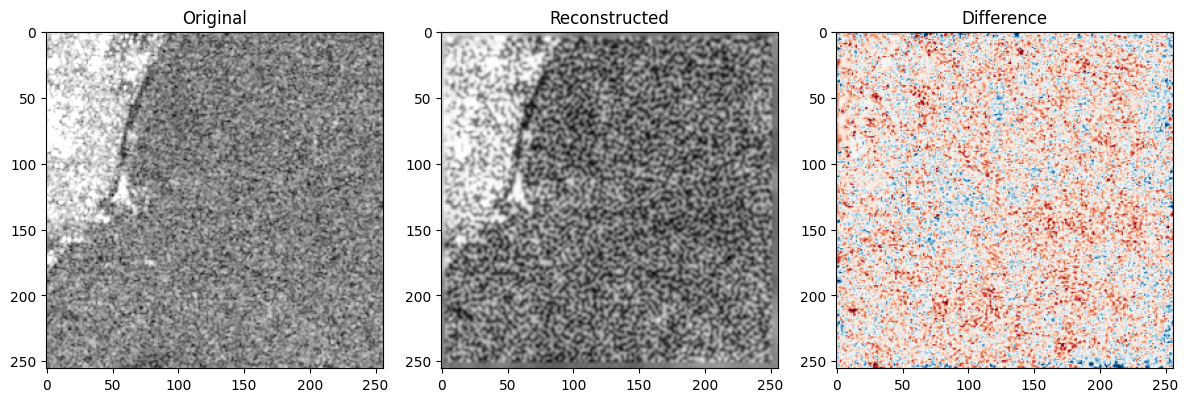

In [29]:
with torch.no_grad():
    recon, _ = model(real_patch)


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(real_patch[0, 0].numpy(), cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(recon[0, 0].numpy(), cmap='gray')
axes[1].set_title('Reconstructed')
axes[2].imshow((real_patch[0, 0] - recon[0, 0]).numpy(), cmap='RdBu_r', vmin=-0.3, vmax=0.3)
axes[2].set_title('Difference')
plt.tight_layout()
plt.show()

In [30]:
from src.evaluation.metrics import SARMetrics
real_patchnp, reconnp = (real_patch.numpy()).flatten(), (recon.numpy()).flatten()
metrics = {}
metrics = {"ssim": SARMetrics.ssim(real_patchnp, reconnp),
            "psnr": SARMetrics.psnr(real_patchnp, reconnp),
            "mse" : SARMetrics.mse(real_patchnp, reconnp)    
        }
print(metrics)

{'ssim': 0.6361079729466818, 'psnr': 20.818641662597656, 'mse': 0.008282013237476349}


In [31]:
from src.evaluation.metrics import enl_ratio

# Load real SAR patch and its reconstruction (from test 6 of Phase 2)
original = patches[0].copy()

with torch.no_grad():
    recon, _ = model(torch.from_numpy(original).unsqueeze(0).unsqueeze(0).float())
reconstructed = recon[0, 0].numpy()

result = enl_ratio(original, reconstructed)
print(f"Keys: {list(result.keys())}")
print(f"ENL ratio: {result['enl_ratio']:.3f}")
print(f"Homogeneous fraction: {result['homogeneous_fraction']:.3f}")

Keys: ['enl_original', 'enl_reconstructed', 'enl_ratio', 'homogeneous_pixels', 'homogeneous_fraction']
ENL ratio: 0.851
Homogeneous fraction: 0.983


In [32]:
from src.evaluation.metrics import edge_preservation_index

epi = edge_preservation_index(original, reconstructed)
print(f"EPI: {epi:.4f}")
print(f"In valid range [0,1]: {0 <= epi <= 1}")
print(f"Good preservation (>0.8): {epi > 0.8}")

EPI: 0.8765
In valid range [0,1]: True
Good preservation (>0.8): True


In [33]:
from src.evaluation.codec_baselines import JPEG2000Codec


codec = JPEG2000Codec()
encoded = codec.encode(original, quality=250)
decoded = codec.decode(encoded)

print(f"Encoded type: {type(encoded)}, size: {len(encoded)} bytes")
print(f"Original shape: {original.shape}, Decoded shape: {decoded.shape}")
psnr = SARMetrics.psnr(original, decoded)
print(f"Roundtrip PSNR: {psnr:.2f} dB")

Encoded type: <class 'bytes'>, size: 16335 bytes
Original shape: (256, 256), Decoded shape: (256, 256)
Roundtrip PSNR: 31.67 dB


In [34]:
from src.evaluation.codec_baselines import CodecEvaluator

codec = JPEG2000Codec()
evaluator = CodecEvaluator(codec)


evaluator.calibrate([16.0], [original])
print(f"Calibrated params: {evaluator.calibrated_params}")

# Evaluate
result = evaluator.evaluate_single(original, target_ratio=16.0)
print(f"Target: 16x, Achieved: {result['achieved_ratio']:.2f}x")
deviation = abs(result['achieved_ratio'] - 16.0) / 16.0 * 100
print(f"Deviation: {deviation:.1f}% (should be <20%)")

Calibrated params: {16.0: 250}
Target: 16x, Achieved: 16.05x
Deviation: 0.3% (should be <20%)


In [35]:
from src.evaluation.evaluator import Evaluator
import os

# Create a minimal evaluator test
evaluator = Evaluator(model, device='cpu')
evaluator.model_name = 'test_model'

batch = torch.from_numpy(patches[:2].copy()).unsqueeze(1).float()
x_hat, metrics = evaluator.evaluate_batch(batch)

# Save results
os.makedirs('evaluations/test_output', exist_ok=True)
evaluator.save_results(
    {'metrics': metrics, 'n_samples': 2},
    'evaluations/test_output',
    'test_model'
)

import glob
files = glob.glob('evaluations/test_output/*.json')
print(f"JSON files created: {[os.path.basename(f) for f in files]}")

Summary saved to: evaluations\test_output\test_model_eval.json
Detailed results saved to: evaluations\test_output\test_model_detailed.json
JSON files created: ['test_model_detailed.json', 'test_model_eval.json']


In [36]:
from src.evaluation.visualizer import Visualizer


os.makedirs('evaluations/test_output/comparisons', exist_ok=True)
viz = Visualizer(save_dir='evaluations/test_output/comparisons')

metrics_dict = {'psnr': 21.2, 'ssim': 0.726, 'epi': 0.876}
fig = viz.plot_comparison(
    original, reconstructed, metrics_dict,
    'test_comparison.png',
    auto_zoom=True,
    show=False
)
print(f"Figure created with {len(fig.axes)} axes")
print(f"File saved: {os.path.exists('evaluations/test_output/comparisons/test_comparison.png')}")

d:\Projects\CNNAutoencoderProject\src\evaluation\visualizer.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved: evaluations\test_output\comparisons\test_comparison.png
Figure created with 10 axes
File saved: True


---

## Done!

**Compare in TensorBoard:**
```bash
tensorboard --logdir=D:/Projects/CNNAutoencoderProject/notebooks/runs
```

Select both `baseline_c16_fast` and `resnet_c16` to compare metrics.

**Next steps:**
- If ResNet still < 25 dB: Try U-Net architecture
- If ResNet >= 25 dB: Proceed to Phase 3 (SAR Evaluation)